# Table of content

1. [Load and prepare the data](#Load-and-prepare-the-data)
    1. [Configuration](#Configuration)
    1. [Load the csv data files](#Load-the-csv-data-files)
    1. [Clean and reshape the data](#Clean-and-reshape-the-data)
1. [Participant rates](#Participant-rates)
    1. [Easy to understand](#Easy-to-understand)
    1. [Mentally easy to use](#Mentally-easy-to-use)
    1. [Physically easy to use](#Physically-easy-to-use)
    1. [Subjective speed](#Subjective-speed)
    1. [Subjective performance](#Subjective-performance)
    1. [Frustration](#Frustration)
1. [Participant trials](#Participant-trials)
    1. [Distributions](#Distributions)
    1. [Completion time](#Completion-time)
    1. [Errors](#Errors)
1. [Bonus](#Bonus)
    1. [Grid configuration](#Grid-configuration)

# Load and prepare the data

## Configuration

In [35]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats

from ast import literal_eval
from os import listdir
from os.path import join

In [2]:
%matplotlib inline

sns.set_style('whitegrid')
sns.set_context('notebook')

## Load the csv data files

The participants information are in `participants`, all the trials in `trials`, and the detailled mesures of the trials in `trial_details`.

In [3]:
participants = pd.read_csv('participants.csv')
trials = pd.read_csv('participants_trials.csv')

In [4]:
# Detailled trials are long to load, keep commented if unused

#trial_details = []
#for file in listdir('.'):
#    if file.endswith('details.csv'): # The trial files end with *-details.csv
#        details.append(pd.read_csv(file))
#trial_details = pd.concat(details, ignore_index=True)

## Clean and reshape the data

Creates `participants_ivs`, `trials_ivs` independent variables lists, and `participants_dps`, `trials_dps` dependent variables list from participants and trials. Used to set up categories on some variables and to set a displaying name on all of them.

In [5]:
# Sets up independent variables lists
participants_iv_labels = participants.loc[:, 'participant_id':'hmd_interactions'].columns
participants_iv_names = ['Participant Id', 'Sex', 'Has Glasses', 'Has Contact Lenses', 'Is Color Blind',\
                         'Age Class', 'Dominant Hand', 'Hand Used for Mouse', 'Activity', 'Computer Hours per Day',\
                         '3D Softwares Used', 'HMD Used', 'Known Interactions Techniques on HMD']
participants_ivs = pd.DataFrame(data=[participants_iv_labels, participants_iv_names],\
                                columns=participants_iv_labels, index=['label', 'name'])

trials_iv_labels = ['technique', 'text_size', 'distance']
trials_iv_names = ['Technique', 'Text Size', 'Distance']
trials_ivs = pd.DataFrame(columns=trials_iv_labels, index=['label', 'name', 'categorical'])

for i in range(len(trials_ivs.columns)):
    iv_label = trials_ivs.columns[i]
    iv_id = iv_label + '_id'
    iv_categories = trials.drop_duplicates(iv_id).loc[:, [iv_id, iv_label]].sort_values([iv_id])
    trials[iv_id] = trials[iv_id].astype(CategoricalDtype(categories=iv_categories[iv_id], ordered=True))
    trials[iv_label] = trials[iv_label].astype(CategoricalDtype(categories=iv_categories[iv_label], ordered=True))
    trials_ivs[iv_label] = [trials_iv_labels[i], trials_iv_names[i],\
                            pd.Categorical(iv_categories[iv_label], iv_categories[iv_label], ordered=True)]

ordering_categories = participants.drop_duplicates('ordering').loc[:, ['ordering']].sort_values(['ordering'])['ordering']
trials_ivs['ordering'] = ['ordering', 'Ordering',\
                          pd.Categorical(ordering_categories, ordering_categories, ordered=True)]

technique_categories = trials_ivs['technique']['categorical'].categories
text_size_categories = trials_ivs['text_size']['categorical'].categories
distance_categories = trials_ivs['distance']['categorical'].categories
ordering_categories = trials_ivs['ordering']['categorical'].categories

In [6]:
# Sets up dependent variables lists
participants_dv_labels = participants.loc[:, 'easy_understand':'frustration'].columns
participants_dv_names = ['Easy to Understand', 'Mentally Easy to Use', 'Physically Easy to Use',\
                         'Subjective Speed', 'Subjective Performance', 'Frustration']
participants_dv_scale = pd.Categorical(list(range(1,6)), list(range(1,6)), ordered=True)
participants_dv_palette = sns.color_palette('RdYlBu', 5)
participants_dvs = pd.DataFrame(data=[participants_dv_labels, participants_dv_names,\
                                      [participants_dv_scale] * len(participants_dv_labels),\
                                      [participants_dv_palette] * len(participants_dv_labels)],\
                                columns=participants_dv_labels, index=['label', 'name', 'scale', 'palette'])

participants_dvs['preference'] = ['preference', 'Preference',\
                                  pd.Categorical(list(range(1,4)), list(range(1,4)), ordered=True),\
                                  [sns.color_palette('RdYlBu', 5)[i] for i in range(4,-1,-2)]]

trials_dv_labels = trials.loc[:, 'total_time':'signed_head_phone_distance'].columns
trials_dv_names = ['Completion Time (s)', 'Selections', 'Total Time Selecting (s)', 'Total Distance Selecting (m)',\
                   'Total Distance Projected on Grid Selecting (m)', 'Deselections', 'Errors', 'Items Classified',\
                   'Number of Pans', 'Total Time Panning (s)', 'Total Distance Panning (m)',\
                   'Total Distance Projected on Grid Panning (m)', 'Number of Zooms', 'Total Time Zooming (s)',\
                   'Total Distance Zooming (m)', 'Total Distance Projected on Grid Zooming (m)',\
                   'Total Head Phone Distance (m)', 'Signed Total Head Phone Distance (m)']
trials_dvs = pd.DataFrame(data=[trials_dv_labels, trials_dv_names],\
                          columns=trials_dv_labels, index=['label', 'name'])

Clean the data:

In [7]:
# Set the participant_id column as the index in participants
participants.set_index('participant_id', inplace=True)

In [8]:
# Some participants are non valid or don't have complete mesures
non_valid_participants = [0]
participants = participants[~participants.index.isin(non_valid_participants)]

incomplete_trials_participant_ids = [0, 4]
trials = trials[~trials['participant_id'].isin(incomplete_trials_participant_ids)].reset_index(drop=True)

# Some participants have wrong head phone mesures
for head_distance_column in ['absolute_head_phone_distance', 'signed_head_phone_distance']:
    trials.loc[trials[head_distance_column] == 0, head_distance_column] = np.nan

In [9]:
# Copy ordering column from participants to trials
trials['ordering'] = [participants.at[participant_id, 'ordering'] for participant_id in trials['participant_id']]
trials['ordering'] = trials['ordering'].astype(trials_ivs['ordering']['categorical'])

In [10]:
# Eval the arrays in some dvs
def eval_if_str(data):
    return literal_eval(data) if isinstance(data, str) else data

for dv_label in participants_dvs.columns:
    participants[dv_label] = participants[dv_label].apply(eval_if_str)

trials['grid_config'] = trials['grid_config'].apply(eval_if_str)

Creates `participants_rates` (extracted from `participants`):

In [11]:
participants_rates = []
for participant_id, participant in participants.iterrows():
    for technique_id in range(len(technique_categories)):
        row = [participant_id]\
               + participant[participants_ivs.loc[:, 'sex':'computer_hours_day'].columns].tolist()\
               + [participant['ordering'], technique_categories[technique_id]]
        participant[participants_dvs.columns].apply(lambda participant_dv: row.append(participant_dv[technique_id]))
        participants_rates.append(row)
        
participants_rates = pd.DataFrame(data=participants_rates,\
                                  columns=participants_ivs.loc[:, 'participant_id':'computer_hours_day'].columns.tolist()\
                                  + ['ordering', 'technique'] + participants_dvs.columns.tolist())

# Restore the categorical IV columns (necessary to maintain the conditions order)
for iv in ['ordering', 'technique']:
    participants_rates[iv] = participants_rates[iv].astype(trials_ivs[iv]['categorical'], copy=False)

Utilities:

In [12]:
participants_dvs_barplot_palette = sns.color_palette('Set2')

# Participant rates

Vizualise, for each 5-points Likert question (5 is the best, 1 is the worst) and for each technique, all the participant rates first, the the mean rate, finally the mean rate dependending of the participant ordering.

Participants tested the techniques in the order:

- (*PhoneOnly*, *PhoneInArOut*, *LeapInArOut*) with ordering 0,
- (*PhoneInArOut*, *LeapInArOut*, *PhoneOnly*) with ordering 1,
- (*LeapInArOut*, *PhoneOnly*, *PhoneInArOut*) with ordering 2.

In [13]:
def get_participants_rates_count(iv_labels, dv_label):
    rates_counts = participants_rates.groupby(iv_labels + [dv_label]).size() # Gets the counts
    
    ivs = [trials_ivs[iv_label]['categorical'] for iv_label in iv_labels]
    rates_counts_index = pd.MultiIndex.from_product(ivs + [participants_dvs.at['scale', dv_label]],\
                                                    names=iv_labels + ['rate'])
    zero_rates_counts = pd.Series(0, index=rates_counts_index)
    
    rates_counts = pd.concat([rates_counts, zero_rates_counts]) # Merge counts with the default counts
    rates_counts = rates_counts[~rates_counts.index.duplicated(keep='first')] # Keeps the counts or the default counts
    rates_counts.sort_index(inplace=True)
    rates_counts.index = rates_counts_index # Restore the index
    return rates_counts

In [14]:
def cumulated_barplot(data, palette, **args):
    for row_index, row in data.iloc[::-1].iterrows():
        sns.barplot(x=row, y=row.index, label=row_index, color=palette[row_index-1], orient='h', **args)

In [15]:
def plot_participants_rates(dv_label):
    iv_technique, iv_ordering = trials_ivs['technique'], trials_ivs['ordering']
    dv = participants_dvs[dv_label]
    
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,5))

    cumulated_rates_count = get_participants_rates_count(['technique'], dv_label).unstack(level=0).cumsum()
    cumulated_barplot(cumulated_rates_count, palette=dv['palette'], ax=axs[0])
    axs[0].set(xlabel='Number of participants', ylabel=iv_technique['name'])
    axs[0].legend(title='Rates', frameon=True)
    
    sns.barplot(x=iv_technique['label'], y=dv['label'], data=participants_rates, palette=participants_dvs_barplot_palette, ax=axs[1])
    axs[1].set(xlabel=iv_technique['name'], ylabel=dv['name'], ylim=(0, dv['scale'][-1]))
    
    sns.barplot(x=iv_ordering['label'], y=dv['label'], hue=iv_technique['label'], data=participants_rates, palette=participants_dvs_barplot_palette, ax=axs[2])
    axs[2].set(xlabel=iv_ordering['name'], ylabel=dv['name'], ylim=(0, dv['scale'][-1]))
    axs[2].legend(title=iv_technique['name'], frameon=True)

## Easy to understand

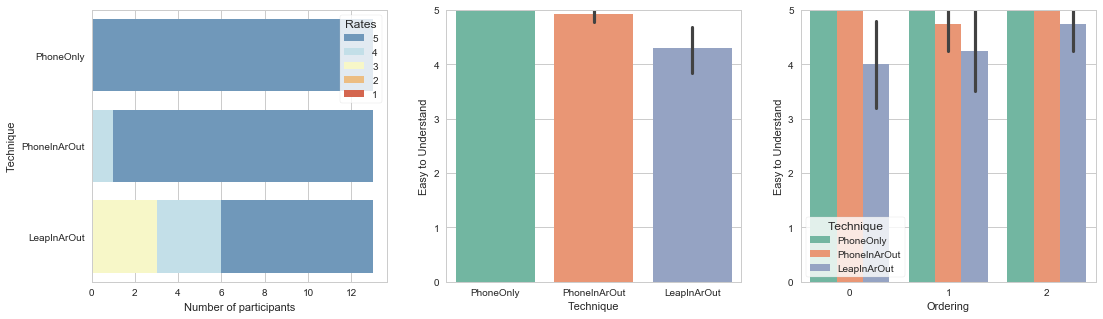

In [16]:
plot_participants_rates('easy_understand')

*LeapInArOut* is harder to understand than the others techniques, particularly when it's the last technique tested (ordering 0). I hypothesised the same, because it presents new interaction techniques.

## Mentally easy to use

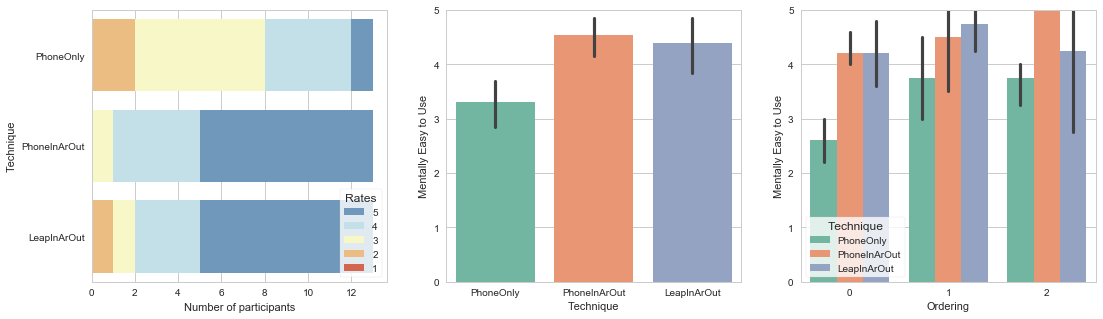

In [17]:
plot_participants_rates('mentally_easy_use')

*PhoneOnly* is mentally more difficult to use mentally than the other techniques, particularly when it's the first technique tested (ordering 0). I hypothesised *PhoneInArOut* to be the easiest to use mentally as the screen is larger and the interaction techniques used are already mastered by the participants.

## Physically easy to use

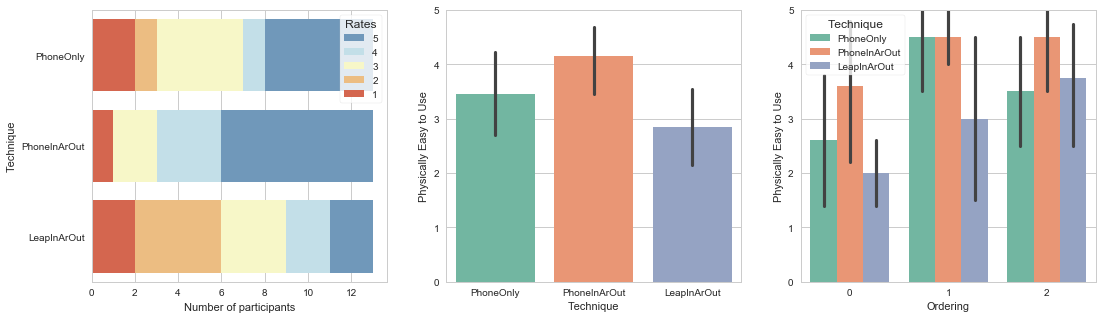

In [18]:
plot_participants_rates('physically_easy_use')

TECHNIQUE has no effect on PHYSICALLY_EASY_USE. I hypothesised *PhoneInArOut* to be the less tiring. But some participants told me that even if the screen is bigger, it demands to pan very often to reach a target (an item or a grid's cell). The same applies to *PhoneOnly*. *LeapInArOut* is also tiring, because the mid-air interactions cause arm fatigue. However, some participants liked the ability to reach directly a target outside the phone's screen.

## Subjective speed

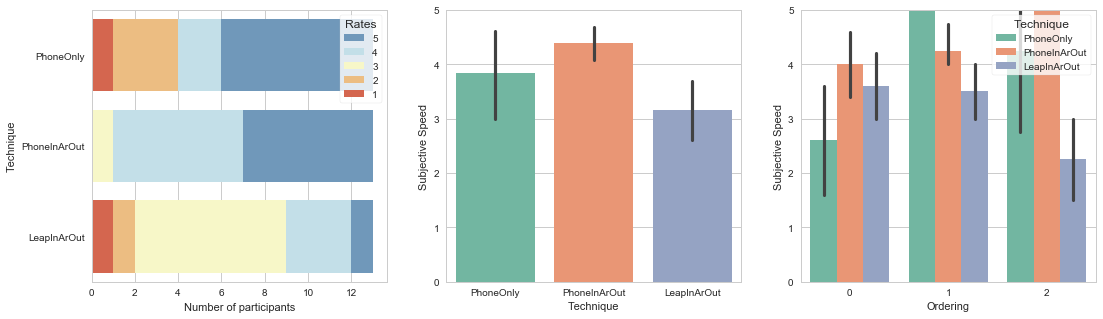

In [19]:
plot_participants_rates('could_go_fast')

## Subjective performance

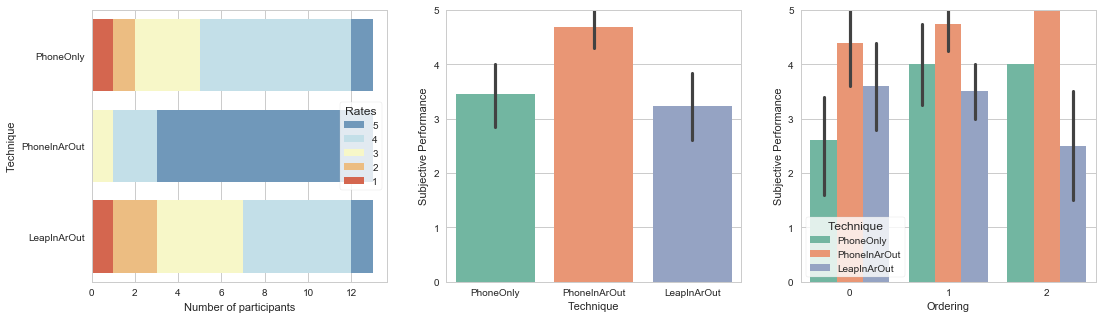

In [20]:
plot_participants_rates('subjective_performance')

## Frustration

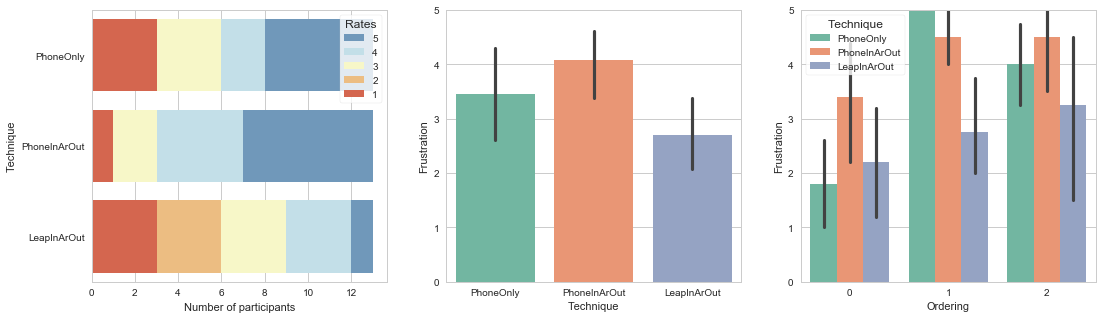

In [21]:
plot_participants_rates('frustration')

## Preference

Visualize the participants preferences (1 is better, 3 is worst):

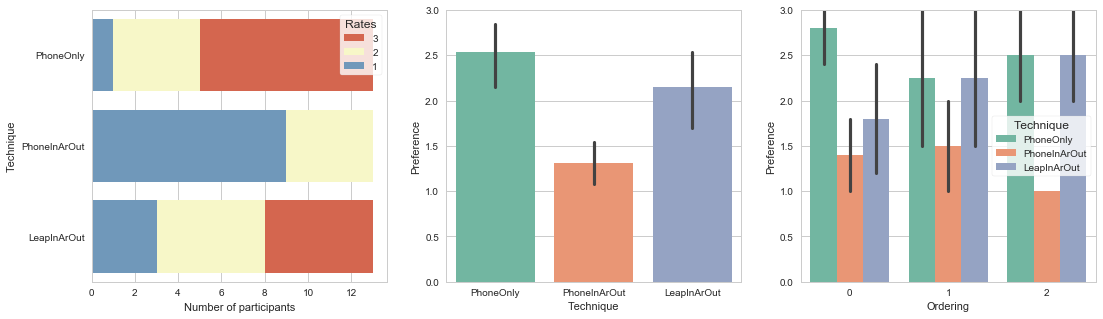

In [22]:
plot_participants_rates('preference')

# Participants trials

In [41]:
def plot_trials(iv_label, dv_label):
    iv, iv_ordering, dv = trials_ivs[iv_label], trials_ivs['ordering'], trials_dvs[dv_label]
    
    fig, axs = plt.subplots(nrows=1, ncols=2, sharey='row', figsize=(12,5))

    sns.barplot(x=iv['label'], y=dv['label'], data=trials, palette=participants_dvs_barplot_palette, ax=axs[0])
    axs[0].set(xlabel=iv['name'], ylabel=dv['name'])

    sns.barplot(x=iv_ordering['label'], y=dv['label'], hue=iv['label'], data=trials, palette=participants_dvs_barplot_palette, ax=axs[1])
    axs[1].set(xlabel=iv_ordering['name'], ylabel=dv['name'])
    axs[1].legend(title=iv['name'], frameon=True)

## Distributions

Visualize the distributions of the trial dependent variables to see if there is outliers. There is a row for each DP, with the technique means at the left and the participant boxplots at the right. The have the same y axis scale.

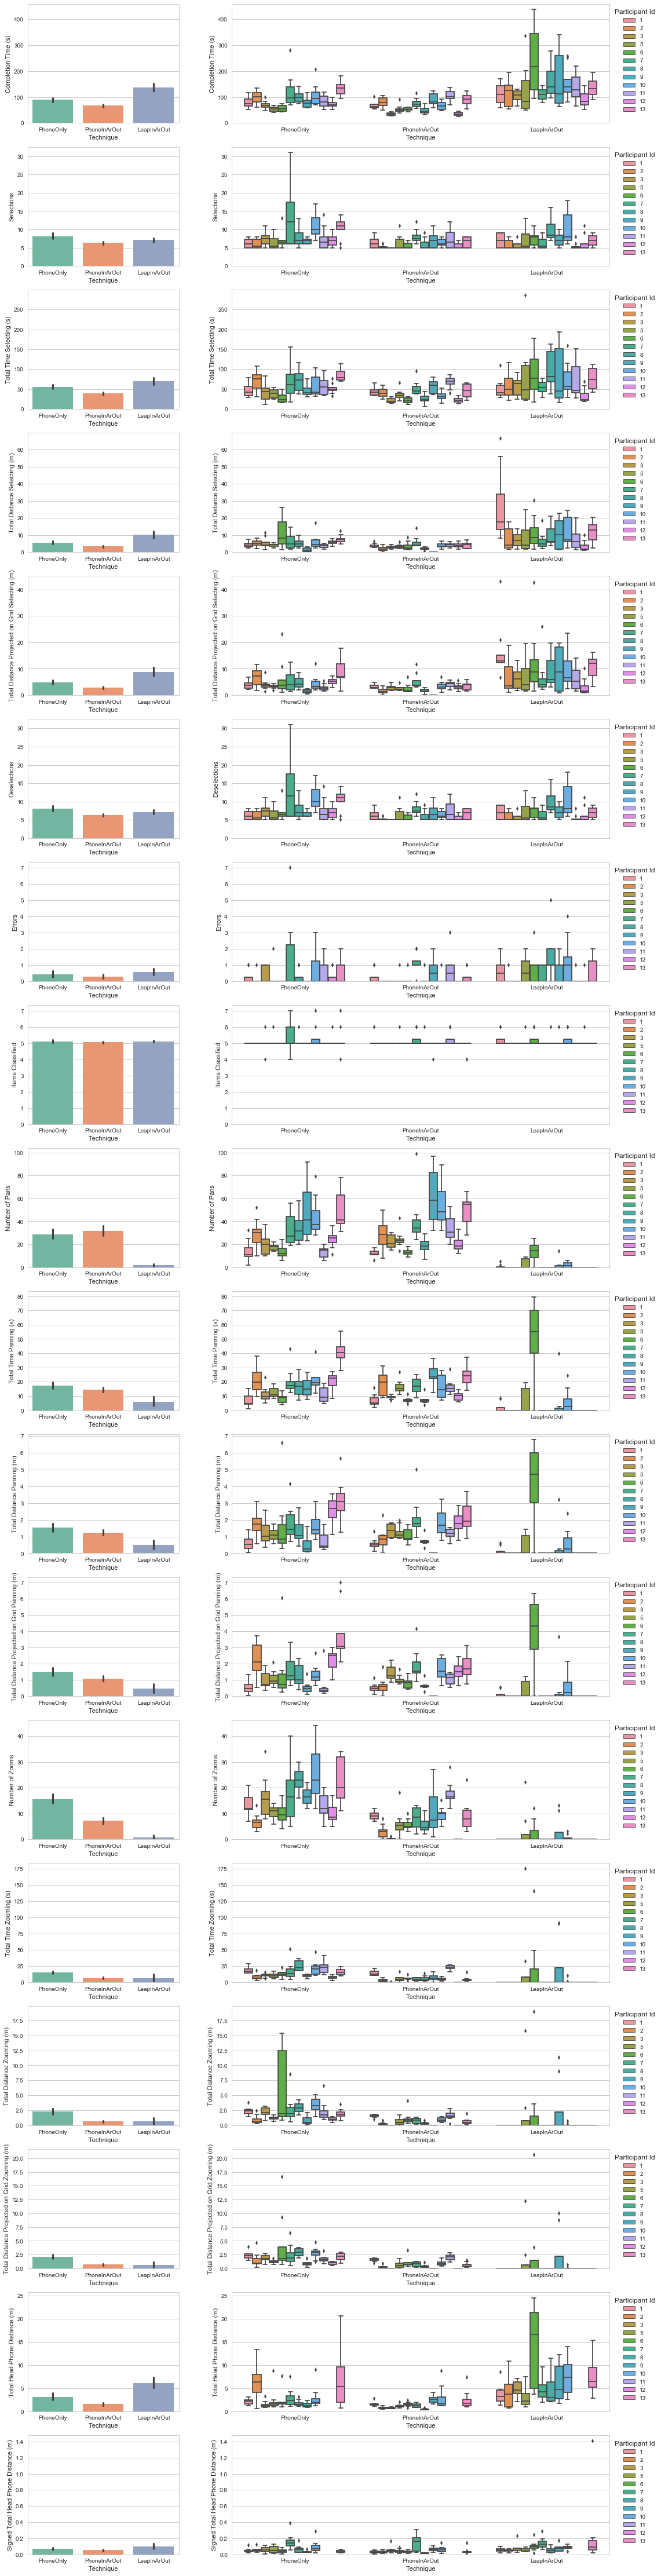

In [39]:
fig = plt.figure(figsize=(18, 4.5 * len(trials_dvs.columns)))
gs = gridspec.GridSpec(nrows=len(trials_dvs.columns), ncols=2, width_ratios=[1, 2.5])

for row in range(len(trials_dvs.columns)):
    iv, dv = trials_ivs['technique'], trials_dvs.iloc[:, row]
    
    ax1 = plt.subplot(gs[2 * row])
    sns.barplot(x=iv['label'], y=dv['label'], data=trials, palette=participants_dvs_barplot_palette, ax=ax1)
    ax1.set(xlabel=iv['name'], ylabel=dv['name'], ylim=(0, None))

    ax2 = plt.subplot(gs[2 * row + 1], sharey=ax1)
    sns.boxplot(x=iv['label'], y=dv['label'], hue='participant_id', data=trials, ax=ax2)
    ax2.set(xlabel=iv['name'], ylabel=dv['name'], ylim=(0, None))
    ax2.legend(title=participants_ivs['participant_id']['name'], loc='upper left', bbox_to_anchor=(1, 1))

## Completion time

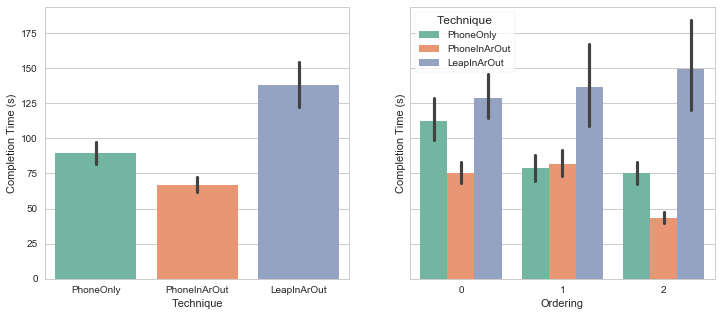

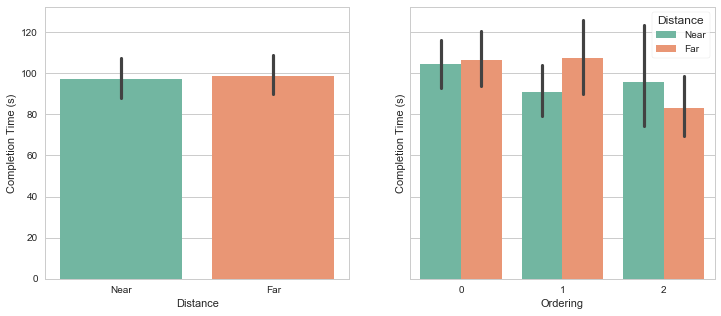

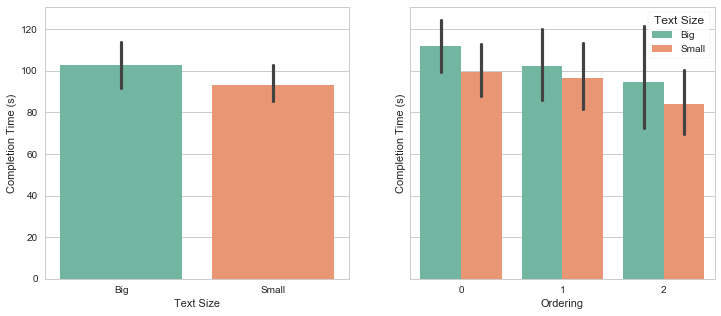

In [43]:
plot_trials('technique', 'total_time')
plot_trials('distance', 'total_time')
plot_trials('text_size', 'total_time')

In [44]:
sm.stats.anova_lm(ols('total_time ~ technique * ordering * text_size * distance', data=trials).fit(), typ=2)

,sum_sq,df,F,PR(>F)
technique,255841.806121,2.0,53.717004,3.599873e-20
ordering,13178.468807,2.0,2.766975,6.475479e-02
text_size,6778.875737,1.0,2.846610,9.279931e-02
distance,245.641705,1.0,0.103151,7.483460e-01
technique:ordering,48542.997144,4.0,5.096087,5.771065e-04
technique:text_size,10681.783844,2.0,2.242766,1.082711e-01
ordering:text_size,575.789748,2.0,0.120894,8.861792e-01
technique:distance,1061.629764,2.0,0.222902,8.003505e-01
ordering:distance,10067.631425,2.0,2.113818,1.229041e-01
text_size:distance,10652.186262,1.0,4.473104,3.541030e-02


TECHNIQUE, ORDERING, TECHNIQUExORDERING, TEXT_SIZExDISTANCE, TECHNIQUExORDERINGxDISTANCE, TECHNIQUExTEXT_SIZExDISTANCE have a significant effect on COMPLETION_TIME. *PhoneInArOut* is the fastest to complete and *LeapInArOut* the longest, like I hypothesised.

## Errors

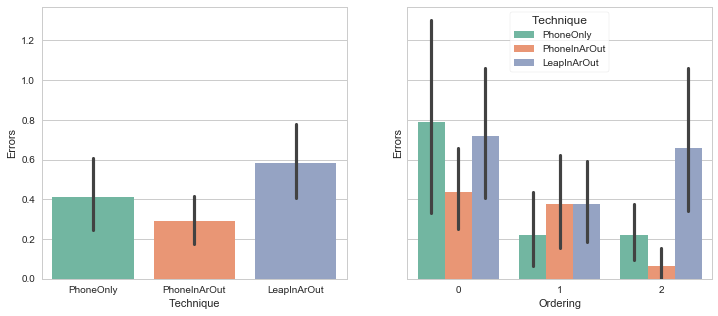

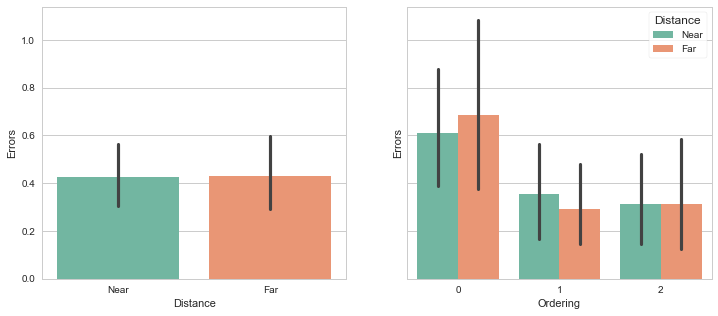

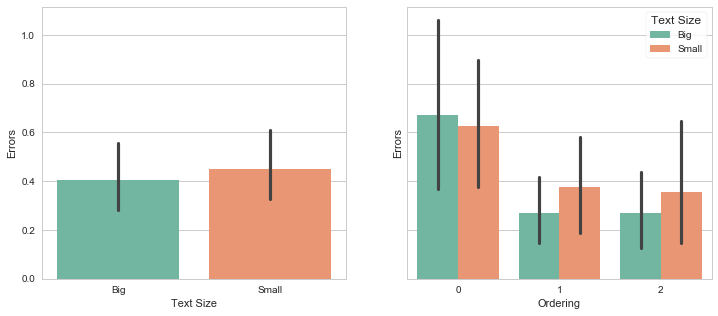

In [45]:
plot_trials('technique', 'errors')
plot_trials('distance', 'errors')
plot_trials('text_size', 'errors')

In [46]:
sm.stats.anova_lm(ols('errors ~ technique * ordering + text_size + distance ', data=trials).fit(), typ=2)

,sum_sq,df,F,PR(>F)
technique,4.130845,2.0,2.979253,0.052456
ordering,7.117158,2.0,5.133045,0.006470
text_size,0.159324,1.0,0.229816,0.632037
distance,0.002026,1.0,0.002922,0.956929
technique:ordering,4.683174,4.0,1.688802,0.152713
Residual,192.728679,278.0,NaN,NaN


None of TECHNIQUE, DISTANCE or TEXT_SIZE have a significant effect on ERRORS. However ORDERING does have an effect.

# Bonus

## Grid configuration

Visualize the distribution of the items to classify:

IndexError: index 3 is out of bounds for axis 0 with size 3

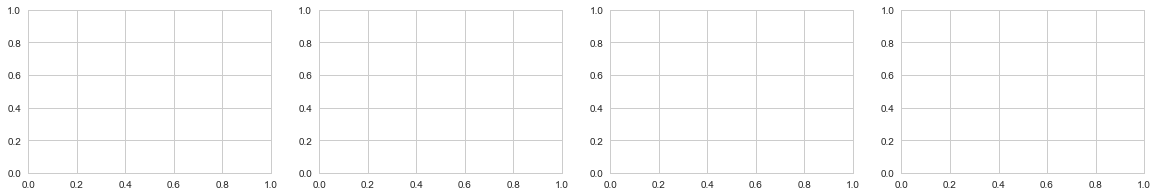

In [52]:
grid_shape, grid_items_count = (5, 3), 5

def count_grid_items_to_classify(participant_ids):
    grid_counts = pd.DataFrame(0, columns=range(grid_shape[1]), index=range(grid_shape[0]))
    for index, grid_config in trials.loc[trials['participant_id'].isin(participant_ids), 'grid_config'].iteritems():
        for i in range(grid_shape[1]):
            for j in range(grid_shape[0]):
                if grid_config[i][j][0] == grid_config[i][j][grid_items_count - 1]:
                    grid_counts.iat[i, j] = grid_counts.iat[i, j] + 1
    return grid_counts

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20,3))

sns.heatmap(countGridItemsToClassify(participants.index.tolist()), vmin=0, annot=True, fmt='d', cmap='YlGnBu', ax=axs[0])
axs[0].set(title='Occurence of items on the grid to classify | all participants')

for i in range(len(ordering)):
    grid_counts = countGridItemsToClassify(participants[participants['ordering'] == ordering[i]]['participant_id'].tolist())
    sns.heatmap(grid_counts, vmin=0, annot=True, fmt='d', cmap='YlGnBu', ax=axs[i+1])
    axs[i+1].set(title='Occurence of items on the grid to classify | ordering ' + str(ordering[i]))